In [1]:
import os.path
import json

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns

plt.style.use(['fivethirtyeight'])
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]

# initial computation of database entry counts to achieve desired sizes

In [2]:
key_size = 16
value_sizes = [16, 256, 4096]
db_sizes_gb = [10, 50, 250]
gb = 1000 ** 3
entry_overhead = 4 # approximate


db_specs = pd.DataFrame([dict(value_size=vs, db_size=gb*ds)
                         for vs in value_sizes for ds in db_sizes_gb])
db_specs['entry_size'] = entry_overhead + key_size + db_specs['value_size']
db_specs['entries'] = db_specs['db_size'] / db_specs['entry_size']
db_specs

,value_size,db_size,entry_size,entries
0,16,10000000000,36,2.777778e+08
1,16,50000000000,36,1.388889e+09
2,16,250000000000,36,6.944444e+09
3,256,10000000000,276,3.623188e+07
4,256,50000000000,276,1.811594e+08
5,256,250000000000,276,9.057971e+08
6,4096,10000000000,4116,2.429543e+06
7,4096,50000000000,4116,1.214772e+07
8,4096,250000000000,4116,6.073858e+07


In [3]:
single_gb_file_specs = db_specs[db_specs['db_size'] == 10*gb].set_index('value_size')['entries'] / 10
single_gb_file_specs

value_size
16      2.777778e+07
256     3.623188e+06
4096    2.429543e+05
Name: entries, dtype: float64

In [4]:
figdir = 'figures/disk_key_value_readonly'
!mkdir -p $figdir

# load results and preprocess data

In [100]:
duration_seconds = 10

def load_results(pathname, disk_name):
    results = []
    with open(f'../benchmarks/disk_key_value/readonly/{pathname}.jsonl', 'rt') as fp:
        for line in fp:
            spec, counts = json.loads(line)
            spec.update(counts)
            results.append(spec)
    results = pd.DataFrame(results)
    results['disk'] = disk_name
    
    results = results[results['seconds'] == duration_seconds]
    
    split_paths = results['data_path'].map(lambda x: x.split(os.path.sep))

    results['data_size'] = split_paths.map(lambda x: int(x[-2].replace('db', '')))
    results['value_size'] = split_paths.map(lambda x: int(x[-3].replace('vs_', '')))
    results['index_rate'] = results['index_path'].map(lambda x: int(os.path.basename(x).replace('index','')))
    results['key_find_rate'] = results['known_key_get_frac']

    results = results.drop(['data_path', 'known_keys_data_path', 'key_set_size',
                            'index_path', 'seconds', 'known_key_get_frac'],
                           axis=1)
    return results

results = pd.concat([
    load_results('i3.2xlarge_2020_04_16', 'NVMe'),
    load_results('c5n.2xlarge_ssd_2020_04_16', 'SSD'),
    load_results('c5n.2xlarge_hdd_2020_04_16', 'HDD')
])

results.sample(5)

,read_threads,trial_index,get,found,disk,data_size,value_size,index_rate,key_find_rate
1661,4,6,8436,821,SSD,250,256,1000,0.1
1804,64,6,16393,8146,HDD,10,256,100,0.5
537,64,9,14061,12600,NVMe,50,4096,1000,0.9
879,16,4,843927,84228,NVMe,250,4096,10,0.1
1227,16,1,3085,291,HDD,50,256,1000,0.1


In [101]:
x = results.copy()
x['get'] /= (duration_seconds * 1000)
agg = x.groupby(['disk', 'data_size', 'index_rate',
                 'value_size', 'key_find_rate', 'read_threads'])['get'].describe()
agg = agg[['count', 'min', '25%', '50%', '75%', 'max']]
agg.sample(5)

count  \
disk data_size index_rate value_size key_find_rate read_threads          
SSD  50        100        256        0.5           1              10.0   
               10         256        0.1           1              10.0   
HDD  10        100        256        0.5           16             10.0   
SSD  250       10         256        0.9           1              10.0   
NVMe 250       1000       4096       0.1           4              10.0   

                                                                    min  \
disk data_size index_rate value_size key_find_rate read_threads           
SSD  50        100        256        0.5           1             1.1112   
               10         256        0.1           1             7.3592   
HDD  10        100        256        0.5           16            0.8121   
SSD  250       10         256        0.9           1             6.1809   
NVMe 250       1000       4096       0.1           4             0.6515   

                                                                      25%  \
disk data_size index_rate value_size key_find_rate read_threads             
SSD  50        100        256        0.5           1             1.151250   
               10         256        0.1           1             8.283475   
HDD  10        100        256        0.5           16            0.994700   
SSD  250       10         256        0.9           1             7.273450   
NVMe 250       1000       4096       0.1           4             0.733775   

                                                                     50%  \
disk data_size index_rate value_size key_find_rate read_threads            
SSD  50        100        256        0.5           1             1.17050   
               10         256        0.1           1             8.68655   
HDD  10        100        256        0.5           16            1.17105   
SSD  250       10         256        0.9           1             7.81315   
NVMe 250       1000       4096       0.1           4             0.73835   

                                                                      75%  \
disk data_size index_rate value_size key_find_rate read_threads             
SSD  50        100        256        0.5           1             1.208700   
               10         256        0.1           1             8.769400   
HDD  10        100        256        0.5           16            1.287050   
SSD  250       10         256        0.9           1             8.058550   
NVMe 250       1000       4096       0.1           4             0.741275   

                                                                    max  
disk data_size index_rate value_size key_find_rate read_threads          
SSD  50        100        256        0.5           1             1.2838  
               10         256        0.1           1             9.0060  
HDD  10        100        256        0.5           16            1.5190  
SSD  250       10         256        0.9           1             8.3319  
NVMe 250       1000       4096       0.1           4             0.7469

In [102]:
incomplete = agg['count'] != 10
if incomplete.sum():
    print('results are incomplete for the following cases')
    display(agg[incomplete])
else:
    print('results are complete')

results are complete


In [103]:
x = agg.sort_values('50%')
display(x.head())
display(x.tail())

count  \
disk data_size index_rate value_size key_find_rate read_threads          
HDD  250       1000       4096       0.5           1              10.0   
     50        1000       4096       0.1           1              10.0   
     250       1000       4096       0.1           1              10.0   
     50        1000       4096       0.9           1              10.0   
     10        1000       256        0.9           1              10.0   

                                                                    min  \
disk data_size index_rate value_size key_find_rate read_threads           
HDD  250       1000       4096       0.5           1             0.0012   
     50        1000       4096       0.1           1             0.0016   
     250       1000       4096       0.1           1             0.0009   
     50        1000       4096       0.9           1             0.0024   
     10        1000       256        0.9           1             0.0001   

                                                                      25%  \
disk data_size index_rate value_size key_find_rate read_threads             
HDD  250       1000       4096       0.5           1             0.004500   
     50        1000       4096       0.1           1             0.005675   
     250       1000       4096       0.1           1             0.005775   
     50        1000       4096       0.9           1             0.006275   
     10        1000       256        0.9           1             0.003625   

                                                                     50%  \
disk data_size index_rate value_size key_find_rate read_threads            
HDD  250       1000       4096       0.5           1             0.00670   
     50        1000       4096       0.1           1             0.00730   
     250       1000       4096       0.1           1             0.00745   
     50        1000       4096       0.9           1             0.00765   
     10        1000       256        0.9           1             0.00820   

                                                                      75%  \
disk data_size index_rate value_size key_find_rate read_threads             
HDD  250       1000       4096       0.5           1             0.008350   
     50        1000       4096       0.1           1             0.008725   
     250       1000       4096       0.1           1             0.009550   
     50        1000       4096       0.9           1             0.008925   
     10        1000       256        0.9           1             0.011025   

                                                                    max  
disk data_size index_rate value_size key_find_rate read_threads          
HDD  250       1000       4096       0.5           1             0.0130  
     50        1000       4096       0.1           1             0.0109  
     250       1000       4096       0.1           1             0.0111  
     50        1000       4096       0.9           1             0.0097  
     10        1000       256        0.9           1             0.0133

count  \
disk data_size index_rate value_size key_find_rate read_threads          
SSD  10        10         4096       0.9           16             10.0   
                                     0.1           64             10.0   
                                     0.5           16             10.0   
                                     0.1           16             10.0   
                                     0.9           64             10.0   

                                                                     min  \
disk data_size index_rate value_size key_find_rate read_threads            
SSD  10        10         4096       0.9           16            53.9517   
                                     0.1           64             9.1914   
                                     0.5           16            77.4448   
                                     0.1           16            69.7231   
                                     0.9           64             6.0884   

                                                                        25%  \
disk data_size index_rate value_size key_find_rate read_threads               
SSD  10        10         4096       0.9           16             92.248675   
                                     0.1           64             53.169325   
                                     0.5           16            106.197475   
                                     0.1           16            116.804550   
                                     0.9           64            100.055800   

                                                                       50%  \
disk data_size index_rate value_size key_find_rate read_threads              
SSD  10        10         4096       0.9           16            108.48045   
                                     0.1           64            109.07205   
                                     0.5           16            113.23915   
                                     0.1           16            141.78495   
                                     0.9           64            144.92790   

                                                                        75%  \
disk data_size index_rate value_size key_find_rate read_threads               
SSD  10        10         4096       0.9           16            134.419450   
                                     0.1           64            136.182525   
                                     0.5           16            128.414825   
                                     0.1           16            144.552100   
                                     0.9           64            148.941800   

                                                                      max  
disk data_size index_rate value_size key_find_rate read_threads            
SSD  10        10         4096       0.9           16            146.3859  
                                     0.1           64            155.5992  
                                     0.5           16            144.5212  
                                     0.1           16            146.3191  
                                     0.9           64            150.1769

Text(0, 0.5, 'Count')

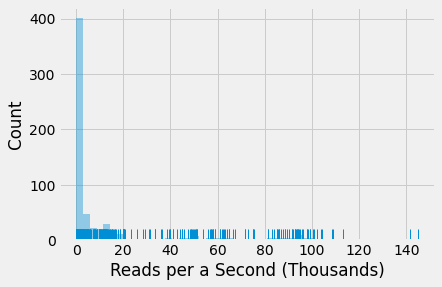

In [104]:
sns.distplot(agg['50%'], kde=False, rug=True, bins=50)
plt.xlabel('Reads per a Second (Thousands)')
plt.ylabel('Count')

# high level analysis of the effect of each individual paramater

In [168]:
sns.boxplot?

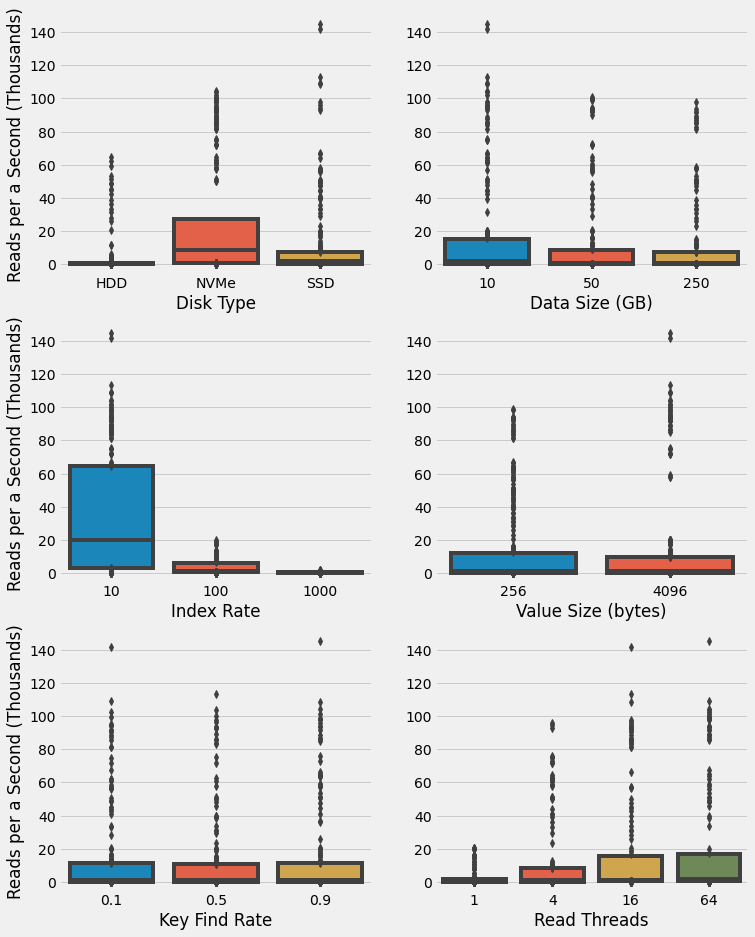

In [174]:
col_description = {
    'disk': 'Disk Type',
    'data_size': 'Data Size (GB)',
    'index_rate': 'Index Rate',
    'value_size': 'Value Size (bytes)',
    'key_find_rate': 'Key Find Rate',
    'read_threads': 'Read Threads'
}

fig = plt.figure(figsize=(11,15))
for i,col in enumerate(agg.index.names):
    ax = fig.add_subplot(3, 2, i + 1)
    sns.boxplot(ax=ax, x=col_description[col], y="50%",
                  data=agg.reset_index().rename(columns={col:col_description[col]}),
                  whis=0)
    plt.ylim(-5, 150)
    plt.ylabel('Reads per a Second (Thousands)' if i%2==0 else '')
    
plt.savefig(figdir + '/benchmarking_indv_param.png', bbox_inches='tight')

In [153]:
x = agg.sort_values('50%', ascending=False).drop(['count'], axis=1).round(1)
x = x.rename_axis(index=col_description)
x = x.head(10)
x = pd.concat({'Reads per a Second (Thousands)': x}, axis=1)
def highlight(x):
    return ['background-color: #FFB27C'] * len(x)

#x = x.style.apply(highlight, subset=[('Reads per a Second (Thousands)', '50%')])
x = x.reset_index()
display(x)
print(' '.join(x.to_html(index=False).split()))
#print(x.to_html())

Disk Type Data Size (GB) Index Rate Value Size (bytes) Key Find Rate  \
                                                                         
0       SSD             10         10               4096           0.9   
1       SSD             10         10               4096           0.1   
2       SSD             10         10               4096           0.5   
3       SSD             10         10               4096           0.1   
4       SSD             10         10               4096           0.9   
5      NVMe             10         10               4096           0.9   
6      NVMe             10         10               4096           0.5   
7      NVMe             10         10               4096           0.1   
8      NVMe             50         10               4096           0.9   
9      NVMe             50         10               4096           0.5   

  Read Threads Reads per a Second (Thousands)                              
                                          min    25%    50%    75%    max  
0           64                            6.1  100.1  144.9  148.9  150.2  
1           16                           69.7  116.8  141.8  144.6  146.3  
2           16                           77.4  106.2  113.2  128.4  144.5  
3           64                            9.2   53.2  109.1  136.2  155.6  
4           16                           54.0   92.2  108.5  134.4  146.4  
5           64                           97.0  101.3  104.5  107.7  109.6  
6           64                           98.1  100.3  103.7  105.8  107.0  
7           64                           96.0   98.9  102.1  103.3  104.5  
8           64                           94.2   97.8  101.1  101.9  105.0  
9           64                           91.9   98.1  100.3  100.8  101.4

<table border="1" class="dataframe"> <thead> <tr> <th>Disk Type</th> <th>Data Size (GB)</th> <th>Index Rate</th> <th>Value Size (bytes)</th> <th>Key Find Rate</th> <th>Read Threads</th> <th colspan="5" halign="left">Reads per a Second (Thousands)</th> </tr> <tr> <th></th> <th></th> <th></th> <th></th> <th></th> <th></th> <th>min</th> <th>25%</th> <th>50%</th> <th>75%</th> <th>max</th> </tr> </thead> <tbody> <tr> <td>SSD</td> <td>10</td> <td>10</td> <td>4096</td> <td>0.9</td> <td>64</td> <td>6.1</td> <td>100.1</td> <td>144.9</td> <td>148.9</td> <td>150.2</td> </tr> <tr> <td>SSD</td> <td>10</td> <td>10</td> <td>4096</td> <td>0.1</td> <td>16</td> <td>69.7</td> <td>116.8</td> <td>141.8</td> <td>144.6</td> <td>146.3</td> </tr> <tr> <td>SSD</td> <td>10</td> <td>10</td> <td>4096</td> <td>0.5</td> <td>16</td> <td>77.4</td> <td>106.2</td> <td>113.2</td> <td>128.4</td> <td>144.5</td> </tr> <tr> <td>SSD</td> <td>10</td> <td>10</td> <td>4096</td> <td>0.1</td> <td>64</td> <td>9.2</td> <td>53.2</td>

# highest performing thread configuration for each set of scoped parameter

In [117]:
disk_colors = dict(zip(sorted(results['disk'].unique()), colors))
index_hatches = dict(zip(sorted(results['index_rate'].unique()), ['/', '*','-']))

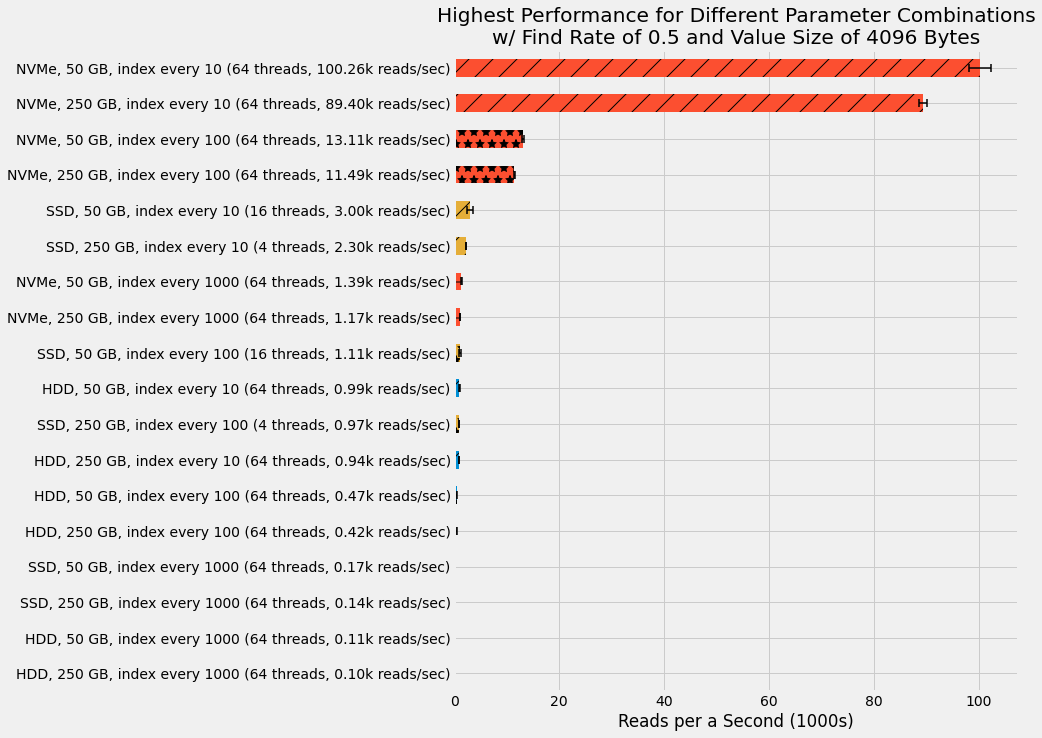

In [160]:
def max_threading(df):
    agg_ops = df.set_index('read_threads')
    idxmax = agg_ops['50%'].idxmax()
    opsmax = agg_ops.loc[idxmax]
    opsmax['read_threads'] = idxmax
    return opsmax

x = agg.reset_index()
x = x[x['key_find_rate'] == 0.5]
x = x[x['value_size'] == 4096]
x = x[x['data_size'].isin([50, 250])]
x = x[x['index_rate'].isin([10, 100, 1000])]
x = (x.groupby(['disk', 'data_size', 'index_rate'])
     .apply(max_threading)
     .sort_values('50%', ascending=True))
iq = x[['25%', '75%']].copy()
iq['25%'] = x['50%'] - iq['25%']
iq['75%'] -= x['50%']
x.plot.barh(figsize=(9, 11), y='50%', xerr=iq.values.T,
            error_kw=dict(ecolor='black', lw=1.5, capsize=4, capthick=1.5),
            color=x.index.to_frame()['disk'].map(disk_colors))
def label(ix):
    r = x.loc[ix]
    disk, db_size, index = ix
    return f'{disk}, {db_size} GB, index every {index} ({r["read_threads"]} threads, {r["50%"]:.2f}k reads/sec)'

ax = plt.gca()
ax.get_legend().remove()
ax.set_yticklabels(map(label, x.index))

for c in ax.get_children():
    try:
        c.set_label('')
    except AttributeError:
        pass
bars = [c for c in ax.get_children() if isinstance(c, matplotlib.patches.Rectangle)]
for (disk, db_size, index), bar in zip(x.index, bars):
    bar.set_hatch(index_hatches[index])

#plt.ylabel('Disk Type, Data Size, Index Rate (Read Threads for Max Reads, Max Reads)')
plt.ylabel('')
plt.xlabel('Reads per a Second (1000s)')
plt.title('Highest Performance for Different Parameter Combinations\n'
          'w/ Find Rate of 0.5 and Value Size of 4096 Bytes')
plt.savefig(figdir + '/disk_datasize_index.png', bbox_inches='tight')

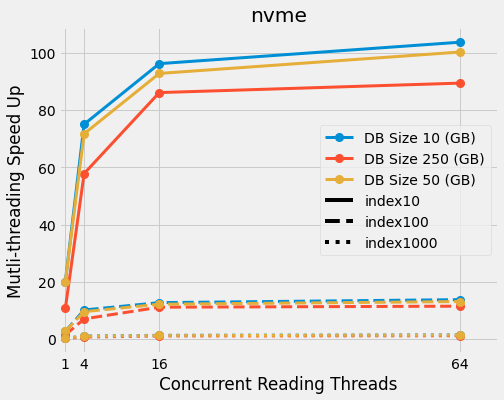

In [12]:
x = agg.reset_index()
x = x[x['known_key_get_frac'] == 0.5]
x = x[x['disk'] == 'nvme']
x = x[x['value_size'] == 4096]

fig = plt.figure(figsize=(7,19))
for i, (disk, x) in enumerate(x.groupby('disk')):
    ax = fig.add_subplot(3, 1, i+1)
    ax.set_title(disk)
    index_lss = {}
    for (index, x),ls in zip(x.groupby('index'), ['-', '--', ':']):
        x = x.copy()
        x['db_size'] = x['db_size'].map(lambda x: f'DB Size {x} (GB)')
        x = x.groupby(['db_size', 'read_threads'])['50%'].apply(lambda x: x.iloc[0]).unstack().T
        x.plot(ax=ax, lw=3, ms=8, marker='o', ls=ls, color=colors[:3:])
        plt.xticks([1, 4, 16, 64])
        plt.ylabel('Mutli-threading Speed Up')
        plt.xlabel('Concurrent Reading Threads')
        index_lss[index] = ls
    for l in ax.get_lines():
        if l.get_linestyle() != '-': 
            l.set_label(None)
    for index, ls in index_lss.items():
        ax.plot([-5, -5], [1, 1], color='k', ls=ls, label=index)

plt.xlim(0, 70)
plt.legend()

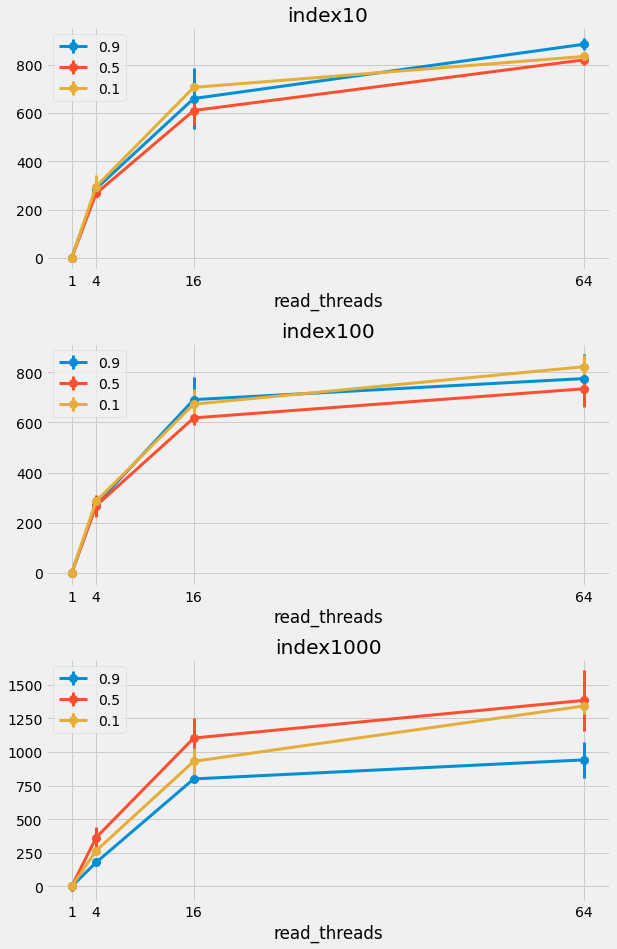

In [13]:
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(hspace=0.3)
x = agg.reset_index()
x = x[x['disk'] == 'hdd']
x = x[x['db_size'] == 250]
x = x[x['value_size'] == 4096]

for i,(index, x) in enumerate(x.groupby('index')):
    ax = fig.add_subplot(3, 1, i+1)
    ax.set_title(index)
    for kkgf, x in list(x.groupby('known_key_get_frac'))[::-1]:
        x = x.set_index('read_threads').copy()
        try:
            t0 = x['50%'].loc[1]
        except KeyError:
            continue
        for c in '25%', '50%', '75%':
            x[c] /= t0
            x[c] -= 1
            x[c] *= 100
        iq = x[['25%', '75%']].copy()
        iq['25%'] = x['50%'] - iq['25%']
        iq['75%'] -= x['50%']

        x.plot(ax=ax, y='50%', yerr=iq.values.T, label=kkgf, marker='o', ms=8, lw=3)
        #ax.set_ylim(-50, 600)
        ax.set_xticks([1, 4, 16, 64])
        ax.legend(loc='upper left')

In [14]:
def other_cols(cols, *wo_cols):
    cols = list(cols)
    for wo_col in wo_cols:
        cols.remove(wo_col)
    return cols

def analyze_col(col, x=agg):
    x = x.reset_index().pivot_table('50%', other_cols(x.index.names, col), [col]).dropna()
    med = x.median(axis=0).sort_values(ascending=True)
    display(med.to_frame().T)
    order_cols = list(med.index)
    x = x[order_cols]
    x['frac'] = x[order_cols[-1]] / x[order_cols[0]]
    display(x['frac'].describe().to_frame().T)
    x = x.sort_values('frac')
    display(x.head(10))
    display(x.tail(10))


In [15]:
analyze_col('value_size')

value_size,4096,256
0,1.0856,1.53755


,count,mean,std,min,25%,50%,75%,max
frac,324.0,4.054945,7.623598,0.025656,0.702,1.450542,3.863627,50.77568


value_size                                                 4096      256  \
disk db_size index     known_key_get_frac read_threads                     
nvme 10      index1000 0.5                4             1.05825  0.02715   
                       0.9                4             1.05955  0.03225   
                                          1             0.28300  0.00875   
                       0.1                1             0.28105  0.00905   
ssd  10      index1000 0.9                4             1.07440  0.03670   
nvme 10      index1000 0.1                4             1.06455  0.03800   
ssd  10      index1000 0.5                4             1.02195  0.04015   
                       0.1                4             1.00205  0.04140   
                       0.9                16            1.91705  0.08505   
nvme 10      index1000 0.9                16            1.31915  0.05990   

value_size                                                  frac  
disk db_size index     known_key_get_frac read_threads            
nvme 10      index1000 0.5                4             0.025656  
                       0.9                4             0.030437  
                                          1             0.030919  
                       0.1                1             0.032201  
ssd  10      index1000 0.9                4             0.034159  
nvme 10      index1000 0.1                4             0.035696  
ssd  10      index1000 0.5                4             0.039288  
                       0.1                4             0.041315  
                       0.9                16            0.044365  
nvme 10      index1000 0.9                16            0.045408

value_size                                               4096       256  \
disk db_size index   known_key_get_frac read_threads                      
hdd  250     index10 0.9                16            0.84185  25.96665   
                     0.1                16            0.82940  28.30350   
     50      index10 0.9                16            1.02465  36.53000   
                     0.1                16            0.89515  33.45660   
     250     index10 0.5                64            0.93950  38.71725   
     50      index10 0.1                64            1.13260  48.53810   
                     0.9                64            1.29260  59.05450   
                     0.5                64            0.98645  45.77410   
     250     index10 0.9                64            1.09120  53.60925   
                     0.1                64            0.96135  48.81320   

value_size                                                 frac  
disk db_size index   known_key_get_frac read_threads             
hdd  250     index10 0.9                16            30.844747  
                     0.1                16            34.125271  
     50      index10 0.9                16            35.651198  
                     0.1                16            37.375412  
     250     index10 0.5                64            41.210484  
     50      index10 0.1                64            42.855465  
                     0.9                64            45.686601  
                     0.5                64            46.402859  
     250     index10 0.9                64            49.128712  
                     0.1                64            50.775680

In [16]:
analyze_col('disk')

disk,hdd,ssd,nvme
0,0.377125,1.8068,8.8459


,count,mean,std,min,25%,50%,75%,max
frac,216.0,30.486724,38.38972,0.736771,4.43622,15.523709,36.279982,178.072655


disk                                                              hdd  \
db_size index     value_size known_key_get_frac read_threads            
10      index1000 256        0.5                4             0.03685   
                             0.9                4             0.04370   
                             0.1                16            0.07910   
                             0.9                16            0.06775   
                             0.1                1             0.01020   
                                                4             0.03915   
                                                64            0.21325   
                             0.9                64            0.22185   
                             0.5                64            0.21030   
                             0.9                1             0.00820   

disk                                                              ssd  \
db_size index     value_size known_key_get_frac read_threads            
10      index1000 256        0.5                4             0.04015   
                             0.9                4             0.03670   
                             0.1                16            0.08190   
                             0.9                16            0.08505   
                             0.1                1             0.01490   
                                                4             0.04140   
                                                64            0.22815   
                             0.9                64            0.21935   
                             0.5                64            0.22420   
                             0.9                1             0.01260   

disk                                                             nvme  \
db_size index     value_size known_key_get_frac read_threads            
10      index1000 256        0.5                4             0.02715   
                             0.9                4             0.03225   
                             0.1                16            0.06625   
                             0.9                16            0.05990   
                             0.1                1             0.00905   
                                                4             0.03800   
                                                64            0.21275   
                             0.9                64            0.22630   
                             0.5                64            0.22190   
                             0.9                1             0.00875   

disk                                                              frac  
db_size index     value_size known_key_get_frac read_threads            
10      index1000 256        0.5                4             0.736771  
                             0.9                4             0.737986  
                             0.1                16            0.837547  
                             0.9                16            0.884133  
                             0.1                1             0.887255  
                                                4             0.970626  
                                                64            0.997655  
                             0.9                64            1.020059  
                             0.5                64            1.055159  
                             0.9                1             1.067073

disk                                                            hdd      ssd  \
db_size index   value_size known_key_get_frac read_threads                     
250     index10 4096       0.5                16            0.72510  2.26770   
                           0.9                4             0.42820  4.92780   
                           0.1                4             0.40690  4.58545   
50      index10 4096       0.9                4             0.49865  7.54310   
250     index10 4096       0.5                4             0.37420  2.30125   
50      index10 4096       0.5                4             0.45345  2.78300   
                           0.1                4             0.45325  8.67785   
                           0.9                1             0.11830  1.96280   
                           0.5                1             0.11380  1.40300   
                           0.1                1             0.11355  1.91210   

disk                                                            nvme  \
db_size index   value_size known_key_get_frac read_threads             
250     index10 4096       0.5                16            86.09130   
                           0.9                4             59.00570   
                           0.1                4             58.17515   
50      index10 4096       0.9                4             72.70010   
250     index10 4096       0.5                4             57.81450   
50      index10 4096       0.5                4             71.71295   
                           0.1                4             71.75070   
                           0.9                1             19.97845   
                           0.5                1             20.10710   
                           0.1                1             20.22015   

disk                                                              frac  
db_size index   value_size known_key_get_frac read_threads              
250     index10 4096       0.5                16            118.730244  
                           0.9                4             137.799393  
                           0.1                4             142.971615  
50      index10 4096       0.9                4             145.793843  
250     index10 4096       0.5                4             154.501603  
50      index10 4096       0.5                4             158.149631  
                           0.1                4             158.302703  
                           0.9                1             168.879544  
                           0.5                1             176.688049  
                           0.1                1             178.072655

In [17]:
analyze_col('known_key_get_frac')

known_key_get_frac,0.5,0.9,0.1
0,1.1156,1.30335,1.31665


,count,mean,std,min,25%,50%,75%,max
frac,216.0,1.154186,0.323979,0.665441,0.990629,1.030127,1.194994,3.118164


known_key_get_frac                                  0.5      0.9      0.1  \
disk db_size index     value_size read_threads                              
nvme 10      index1000 256        1             0.01360  0.00875  0.00905   
ssd  10      index100  4096       1             2.52985  2.04715  1.83425   
             index1000 4096       64            1.67190  1.22020  1.31965   
hdd  50      index1000 4096       1             0.00870  0.00765  0.00730   
     10      index10   4096       16            3.59965  5.83615  3.02575   
nvme 50      index1000 256        16            0.38960  0.35740  0.33045   
ssd  50      index1000 256        1             0.06535  0.07415  0.05660   
hdd  10      index1000 256        1             0.01175  0.00820  0.01020   
     250     index1000 4096       4             0.03100  0.02650  0.02715   
     10      index10   4096       4             0.99205  1.61730  0.86955   

known_key_get_frac                                  frac  
disk db_size index     value_size read_threads            
nvme 10      index1000 256        1             0.665441  
ssd  10      index100  4096       1             0.725043  
             index1000 4096       64            0.789312  
hdd  50      index1000 4096       1             0.839080  
     10      index10   4096       16            0.840568  
nvme 50      index1000 256        16            0.848178  
ssd  50      index1000 256        1             0.866106  
hdd  10      index1000 256        1             0.868085  
     250     index1000 4096       4             0.875806  
     10      index10   4096       4             0.876518

known_key_get_frac                                   0.5       0.9       0.1  \
disk db_size index     value_size read_threads                                 
ssd  250     index10   4096       4              2.30125   4.92780   4.58545   
     10      index100  4096       64             9.87740  17.73310  19.76580   
     50      index10   4096       64             2.10130   5.48355   4.23185   
             index100  256        16             2.46525   4.99610   5.00815   
     250     index10   4096       16             2.26770   4.87765   4.80835   
     50      index100  256        64             2.38790   5.09315   5.08895   
             index10   4096       16             3.00330   7.42320   6.40590   
hdd  250     index10   256        16            11.83105  25.96665  28.30350   
ssd  10      index1000 4096       16             0.69190   1.91705   1.77935   
     50      index10   4096       4              2.78300   7.54310   8.67785   

known_key_get_frac                                  frac  
disk db_size index     value_size read_threads            
ssd  250     index10   4096       4             1.992591  
     10      index100  4096       64            2.001114  
     50      index10   4096       64            2.013920  
             index100  256        16            2.031498  
     250     index10   4096       16            2.120364  
     50      index100  256        64            2.131140  
             index10   4096       16            2.132954  
hdd  250     index10   256        16            2.392307  
ssd  10      index1000 4096       16            2.571687  
     50      index10   4096       4             3.118164

In [18]:
analyze_col('index')

index,index1000,index100,index10
0,0.210625,1.6049,20.216825


,count,mean,std,min,25%,50%,75%,max
frac,216.0,180.133472,361.422388,7.027893,19.455116,68.681604,113.046956,2243.904236


index                                                    index1000  index100  \
disk db_size value_size known_key_get_frac read_threads                        
hdd  250     256        0.5                1               0.04840   0.12535   
                        0.9                1               0.04955   0.12010   
                        0.1                1               0.04815   0.12850   
             4096       0.1                64              0.10750   0.44660   
     50      4096       0.5                64              0.10990   0.46645   
     250     4096       0.5                16              0.08065   0.36455   
             256        0.5                4               0.19300   0.47330   
     10      4096       0.1                4               0.09505   0.21270   
     250     4096       0.5                64              0.09945   0.42350   
                        0.9                16              0.08590   0.39445   

index                                                    index10      frac  
disk db_size value_size known_key_get_frac read_threads                     
hdd  250     256        0.5                1             0.34015  7.027893  
                        0.9                1             0.34905  7.044400  
                        0.1                1             0.37160  7.717549  
             4096       0.1                64            0.96135  8.942791  
     50      4096       0.5                64            0.98645  8.975887  
     250     4096       0.5                16            0.72510  8.990701  
             256        0.5                4             1.74315  9.031865  
     10      4096       0.1                4             0.86955  9.148343  
     250     4096       0.5                64            0.93950  9.446958  
                        0.9                16            0.84185  9.800349

index                                                    index1000  index100  \
disk db_size value_size known_key_get_frac read_threads                        
nvme 10      256        0.5                1               0.01360   0.98420   
                                           16              0.07060   5.08700   
                        0.1                16              0.06625   4.56460   
ssd  10      256        0.9                4               0.03670   3.44785   
nvme 10      256        0.9                16              0.05990   5.01455   
                        0.1                4               0.03800   3.51925   
                                           1               0.00905   1.01620   
                        0.9                1               0.00875   1.04735   
                                           4               0.03225   3.60480   
                        0.5                4               0.02715   3.31340   

index                                                     index10         frac  
disk db_size value_size known_key_get_frac read_threads                         
nvme 10      256        0.5                1             15.40510  1132.727941  
                                           16            84.02150  1190.106232  
                        0.1                16            81.45515  1229.511698  
ssd  10      256        0.9                4             50.96510  1388.694823  
nvme 10      256        0.9                16            88.55650  1478.405676  
                        0.1                4             61.97355  1630.882895  
                                           1             16.05595  1774.138122  
                        0.9                1             16.27285  1859.754286  
                                           4             63.24720  1961.153488  
                        0.5                4             60.92200  2243.904236

In [19]:
analyze_col('db_size')

db_size,50,250,10
0,1.1565,1.16545,1.8068


,count,mean,std,min,25%,50%,75%,max
frac,216.0,3.08104,6.082214,0.163872,0.855295,1.067655,1.822254,46.542521


db_size                                                         50      250  \
disk index     value_size known_key_get_frac read_threads                     
nvme index1000 256        0.9                4             0.19680  0.87940   
                          0.5                4             0.16430  0.85490   
                          0.9                16            0.35740  1.22675   
ssd  index1000 256        0.5                1             0.06535  0.27010   
                          0.9                1             0.07415  0.28090   
                                             4             0.21290  0.98655   
                          0.1                4             0.23585  0.96810   
nvme index1000 256        0.1                1             0.05135  0.26345   
                          0.5                16            0.38960  1.24950   
ssd  index1000 256        0.5                4             0.20920  0.91990   

db_size                                                         10      frac  
disk index     value_size known_key_get_frac read_threads                     
nvme index1000 256        0.9                4             0.03225  0.163872  
                          0.5                4             0.02715  0.165247  
                          0.9                16            0.05990  0.167599  
ssd  index1000 256        0.5                1             0.01110  0.169855  
                          0.9                1             0.01260  0.169926  
                                             4             0.03670  0.172381  
                          0.1                4             0.04140  0.175535  
nvme index1000 256        0.1                1             0.00905  0.176241  
                          0.5                16            0.07060  0.181211  
ssd  index1000 256        0.5                4             0.04015  0.191922

db_size                                                        50      250  \
disk index    value_size known_key_get_frac read_threads                     
ssd  index10  4096       0.9                16            7.42320  4.87765   
     index100 4096       0.9                64            1.06945  0.93895   
                         0.5                16            1.11140  0.95425   
                         0.1                64            1.05115  0.91420   
     index10  4096       0.1                16            6.40590  4.80835   
                                            64            4.23185  2.96490   
                         0.9                64            5.48355  3.25815   
                         0.5                4             2.78300  2.30125   
                                            16            3.00330  2.26770   
                                            64            2.10130  1.88155   

db_size                                                          10       frac  
disk index    value_size known_key_get_frac read_threads                        
ssd  index10  4096       0.9                16            108.48045  14.613704  
     index100 4096       0.9                64             17.73310  16.581514  
                         0.5                16             18.63935  16.771055  
                         0.1                64             19.76580  18.803977  
     index10  4096       0.1                16            141.78495  22.133494  
                                            64            109.07205  25.774082  
                         0.9                64            144.92790  26.429576  
                         0.5                4              92.81500  33.350701  
                                            16            113.23915  37.704908  
                                            64             97.79980  46.542521

In [20]:
analyze_col('read_threads')

read_threads,1,4,16,64
0,0.319975,1.087425,1.426875,1.6118


,count,mean,std,min,25%,50%,75%,max
frac,162.0,15.548979,30.393718,1.349146,5.061183,6.580056,11.922854,171.371155


read_threads                                                1        4  \
disk db_size index     value_size known_key_get_frac                     
ssd  250     index1000 4096       0.5                 0.10540  0.13905   
                                  0.1                 0.10515  0.13945   
                                  0.9                 0.10535  0.14115   
     50      index1000 4096       0.1                 0.11030  0.16920   
             index10   4096       0.5                 1.40300  2.78300   
             index1000 4096       0.5                 0.11230  0.16620   
     250     index10   4096       0.5                 1.21035  2.30125   
     50      index1000 4096       0.9                 0.11460  0.15985   
     250     index100  4096       0.5                 0.49675  0.97425   
     50      index100  4096       0.5                 0.58460  1.10045   

read_threads                                               16       64  \
disk db_size index     value_size known_key_get_frac                     
ssd  250     index1000 4096       0.5                 0.13925  0.14220   
                                  0.1                 0.13970  0.14570   
                                  0.9                 0.14260  0.14620   
     50      index1000 4096       0.1                 0.15965  0.16445   
             index10   4096       0.5                 3.00330  2.10130   
             index1000 4096       0.5                 0.16425  0.16970   
     250     index10   4096       0.5                 2.26770  1.88155   
     50      index1000 4096       0.9                 0.16630  0.17845   
     250     index100  4096       0.5                 0.95425  0.78025   
     50      index100  4096       0.5                 1.11140  0.93790   

read_threads                                              frac  
disk db_size index     value_size known_key_get_frac            
ssd  250     index1000 4096       0.5                 1.349146  
                                  0.1                 1.385640  
                                  0.9                 1.387755  
     50      index1000 4096       0.1                 1.490934  
             index10   4096       0.5                 1.497719  
             index1000 4096       0.5                 1.511131  
     250     index10   4096       0.5                 1.554550  
     50      index1000 4096       0.9                 1.557155  
     250     index100  4096       0.5                 1.570710  
     50      index100  4096       0.5                 1.604345

read_threads                                              1        4  \
disk db_size index   value_size known_key_get_frac                     
hdd  10      index10 4096       0.9                 0.29980  1.61730   
                     256        0.5                 0.46920  2.98500   
     250     index10 256        0.5                 0.34015  1.74315   
     50      index10 256        0.5                 0.36830  2.02445   
     250     index10 256        0.1                 0.37160  2.93475   
     50      index10 256        0.1                 0.35890  3.26450   
     10      index10 256        0.9                 0.45185  6.04105   
                                0.1                 0.41725  4.35735   
     250     index10 256        0.9                 0.34905  3.00515   
     50      index10 256        0.9                 0.34460  3.64920   

read_threads                                              16        64  \
disk db_size index   value_size known_key_get_frac                       
hdd  10      index10 4096       0.9                  5.83615  11.98530   
                     256        0.5                 31.32560  51.24050   
     250     index10 256        0.5                 11.83105  38.71725   
     50      index10 256        0.5                 20.54495  45.77410   
     250     index10 256        0.1                 28.30350  48.81320   
     50      index10 256        0.1                 33.45660  48.53810   
     10      index10 256        0.9                 44.87955  64.84800   
                                0.1                 42.63405  62.29010   
     250     index10 256        0.9                 25.96665  53.60925   
     50      index10 256        0.9                 36.53000  59.05450   

read_threads                                              frac  
disk db_size index   value_size known_key_get_frac              
hdd  10      index10 4096       0.9                  39.977652  
                     256        0.5                 109.208227  
     250     index10 256        0.5                 113.824048  
     50      index10 256        0.5                 124.284822  
     250     index10 256        0.1                 131.359526  
     50      index10 256        0.1                 135.241293  
     10      index10 256        0.9                 143.516654  
                                0.1                 149.287238  
     250     index10 256        0.9                 153.586162  
     50      index10 256        0.9                 171.371155

In [21]:
for col in agg.index.names:
    display(agg.reset_index().groupby(col)['50%'].median().sort_values().to_frame().T)

disk,hdd,ssd,nvme
50%,0.377125,1.8068,8.8459


db_size,50,250,10
50%,1.1565,1.16545,1.8068


index,index1000,index100,index10
50%,0.210625,1.6049,20.216825


value_size,4096,256
50%,1.0856,1.53755


known_key_get_frac,0.5,0.9,0.1
50%,1.1156,1.30335,1.31665


read_threads,1,4,16,64
50%,0.319975,1.087425,1.426875,1.6118


/home/matt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Unrecognized location 'Upper Right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Density of Scenarios')

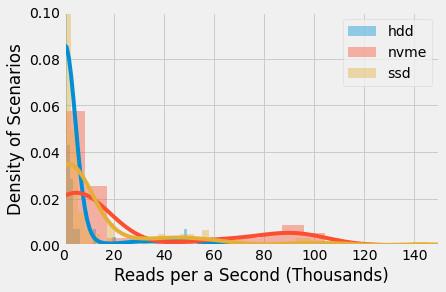

In [22]:
for color,(disk, dist) in zip(colors, agg.groupby('disk')['50%']):
    sns.distplot(dist, color=color, label=disk)
plt.legend(loc='Upper Right')
plt.ylim(0, 0.1)
plt.xlim(0, 150)
plt.xlabel('Reads per a Second (Thousands)')
plt.ylabel('Density of Scenarios')

# System Specs for Write Up

In [175]:
x = pd.DataFrame([
    ['NVMe', 'i3.2xlarge', 8, 61, 'n/a', 180],
    ['SSD', 'c5n.2xlarge', 8, 21, 'gp2', 3],
    ['HDD', 'c5n.2xlarge', 8, 21, 'standard', '0.04 - 0.2'],

], columns=['Type', 'Instance Type', 'vCPUs', 'RAM (GiB)', 'EBS Volume Type', 'Provisioned IOPs (Thousands)'])
print(' '.join(x.to_html(index=False).split()))

<table border="1" class="dataframe"> <thead> <tr style="text-align: right;"> <th>Type</th> <th>Instance Type</th> <th>vCPUs</th> <th>RAM (GiB)</th> <th>EBS Volume Type</th> <th>Provisioned IOPs (Thousands)</th> </tr> </thead> <tbody> <tr> <td>NVMe</td> <td>i3.2xlarge</td> <td>8</td> <td>61</td> <td>n/a</td> <td>180</td> </tr> <tr> <td>SSD</td> <td>c5n.2xlarge</td> <td>8</td> <td>21</td> <td>gp2</td> <td>3</td> </tr> <tr> <td>HDD</td> <td>c5n.2xlarge</td> <td>8</td> <td>21</td> <td>standard</td> <td>0.04 - 0.2</td> </tr> </tbody> </table>
